_Aboa Bouadou, Rose Guionnet, Nathan Laîné, Victor Devys, Tino Margely_

# Modèle multi machine avec maximiation de rendement

In [299]:
def dataframe_to_list(data):
    dataframe = data.copy()
    #dataframe = dataframe
    min_date = dataframe['disp'].min().to_pydatetime()
    dataframe['disp'] = dataframe['disp'].apply(lambda x: (x.to_pydatetime()- min_date).total_seconds()/SECONDS_PER_DAY)
    dataframe['max'] = dataframe['max'].apply(lambda x: (x.to_pydatetime()-min_date).total_seconds()/SECONDS_PER_DAY)
    dataframe['durée'] = dataframe['durée']
    
    return(list(dataframe['disp']),list(dataframe['max']),list(dataframe['durée']))

In [300]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import math
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib import pyplot as plt
import copy
import time
from pulp import *
import matplotlib.patches as patches
import matplotlib.colors as mcolors

In [301]:
SECONDS_PER_DAY = 24*60*60

In [302]:
data = pd.read_excel("data/raw/Orano-données-Double.xlsx", sheet_name="Optim", header=5, usecols=[3,4,5,6,7], nrows=47)

# Multi machines

In [303]:
def solvePLNEMultiMachines(disp, dmax, duree,M,bigM,mu,a):    
    
    Tasks=range(len(disp)) #Liste des taches 
    Machine=range(M)
    
    model = LpProblem("Orano", LpMaximize)
    
    # Variables 
    y = LpVariable.dicts("y",((i,m) for i in Tasks for m in Machine),0,1,LpInteger) #y_{i}^m si i est usinée sur la machine m
    x = LpVariable.dicts("x", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger) #x_{i,j}^m=1 si i est usinée avant j
    deb = LpVariable.dicts("deb", Tasks,0, None)
    dem = LpVariable.dicts("dem", Tasks,0, None)
    real = LpVariable.dicts("real", Tasks,0, None)
    marge = LpVariable.dicts("marge", Tasks,0, None)
    z3 = LpVariable.dicts("z3", ((i,j,k,m) for i in Tasks for j in Tasks for k in Tasks for m in Machine),0,1,LpInteger)
    z2 = LpVariable.dicts("z2", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger)
    liv = LpVariable.dicts("liv", Tasks,0, None)
    W = LpVariable("W", lowBound=0)
    
    # Contraintes :
    for j in Tasks:
        
        for m in Machine:
            model += x[j,j,m] == 0 
            
        model += lpSum(y[j,m] for m in Machine)==1
        model += dem[j] >= disp[j]
        model += real[j] == dem[j] + duree[j] 
        model += W <= marge[j]
        model += liv[j] == deb[j] + 30
        model += liv[j] <= dmax[j]
        model += marge[j] == dmax[j] - liv[j]
        model += deb[j] >= real[j]
        
        for m in Machine:
            model += dem[j] >= lpSum(duree[i]*x[i,j,m] for i in Tasks)
        
        for i in Tasks:
            if i != j:
                for m in Machine:
                    #model += dem[j]>= real[i]-bigM*(1-x[i,j,m])
                    model += z2[j,i,m] <= y[i,m]
                    model += z2[j,i,m] <= y[j,m]
                    model += z2[j,i,m] >= (y[i,m]+y[j,m])-1
                    model += z2[j,i,m] >= 0
                    model += x[i,j,m]+x[j,i,m]==z2[i,j,m]
                    model += x[j,i,m]<=z2[i,j,m]
                
            for k in Tasks:
                if i!=j and i!=k and j!=k:
                    for m in Machine : 
                        model += z3[i,j,k,m] <= y[i,m]
                        model += z3[i,j,k,m] <= y[j,m]
                        model += z3[i,j,k,m] <= y[k,m]
                        model += z3[i,j,k,m] >= (y[i,m]+y[j,m]+y[k,m])-2
                        model += z3[i,j,k,m] >= 0
                        model += x[i,j,m]+x[j,k,m]-1 <= x[i,k,m]+bigM*(1-z3[i,j,k,m])
                
    # Objectif : 
    model+= W 
    #+0.5*lpSum(mu[i]*a[m]*y[i,m] for i in Tasks for m in Machine)
    
    #Resolution du PLNE : 
    starttime=time.time() #Pour avoir le temps d'execution
    model.solve(PULP_CBC_CMD(maxSeconds=60))
    solveTime=time.time()-starttime
    
    #Affichage des éléments de résolution
    f_val=[]
    for i in range(0,len(Tasks)):
        f_val.append(model.variables()[i].varValue)
    order=np.argsort(f_val)
    
        
    print("Temps de résolution = ", solveTime)
    print("Statut de la solution = ", LpStatus[model.status])
    print("Valeur optimale = ", value(model.objective))
 #   print("Ordre des taches =",order)
 #   print("####################")
 #   for i in range(len(Tasks)+1):
 #       print(model.variables()[i], model.variables()[i].value())
 #   print("####################")
 #   for i in range(len(Tasks)+1,2*len(Tasks)+1):
 #       print(model.variables()[i], model.variables()[i].value())
 #   print("####################")
 #   for i in range(2*len(Tasks)+1,3*len(Tasks)+1):
 #       print(model.variables()[i], model.variables()[i].value())
 #   print("####################")
 #   for i in range(3*len(Tasks)+1,4*len(Tasks)+1):
 #       print(model.variables()[i], model.variables()[i].value())
 #   print("####################")
 #   for i in range(4*len(Tasks)+1,5*len(Tasks)+1):
 #       print(model.variables()[i], model.variables()[i].value())
 #   print("####################")
 #   for i in range(13*len(Tasks)+1,15*len(Tasks)+1):
 #       print(model.variables()[i], model.variables()[i].value())
    return(solveTime,value(model.objective),model.variables())

In [304]:
data = pd.read_excel("data/raw/Orano-données-Double.xlsx", sheet_name="Optim", header=5, usecols=[3,4,5,6,7], nrows=47)
n = 15
disp, dmax, duree = dataframe_to_list(data)
disp, dmax, duree = disp[:n], dmax[:n], duree[:n]


In [305]:
a=[12,-8]
mu=np.random.uniform(0.1,0.7,15)
[t,price,var]=solvePLNEMultiMachines(disp, dmax, duree,2,10**6,mu,a)

Temps de résolution =  50.09161996841431
Statut de la solution =  Optimal
Valeur optimale =  31.488563


# Affichage

In [310]:
def printEDT(var):
    varsdict = {}
    for v in var:
        varsdict[v.name] = v.varValue

    dem=["dem_{}".format(i) for i in range(len(Tasks))]
    demVal=[varsdict[dem[i]] for i in range(len(dem))]
    deb=["deb_{}".format(i) for i in range(len(Tasks))]
    debVal=[varsdict[deb[i]] for i in range(len(dem))]
    liv=["liv_{}".format(i) for i in range(len(Tasks))]
    livVal=[varsdict[liv[i]] for i in range(len(dem))]
    marge=["marge_{}".format(i) for i in range(len(Tasks))]
    margeVal=[varsdict[marge[i]] for i in range(len(dem))]
    real=["real_{}".format(i) for i in range(len(Tasks))]
    realVal=[varsdict[real[i]] for i in range(len(dem))]
    y=[('y_('+str(i)+',_'+str(j)+')') for i in range(len(Tasks)) for j in range(M)]

    machine=[[] for m in range(M)]
    real2=[[] for m in range(M)]
    dem2=[[] for m in range(M)]
    deb2=[[] for m in range(M)]
    liv2=[[] for m in range(M)]

    for task in range(len(Tasks)):
        for m in range(M): 
            if(varsdict[('y_('+str(task)+',_'+str(m)+')')]==1):
                machine[m].append(task)
                real2[m].append(realVal[task])
                dem2[m].append(demVal[task])
                deb2[m].append(debVal[task])
                liv2[m].append(livVal[task])
                break
    print('PLANIFICATION :')     
    for m in range(len(machine)):
        
        deb=dict(zip(machine[m],deb2[m]))
        dem=dict(zip(machine[m],dem2[m]))
        real=dict(zip(machine[m],real2[m]))
        liv=dict(zip(machine[m],liv2[m]))
        order=sorted(deb,key=deb.get)
        plt.clf()
        fig, axs = plt.subplots(figsize=(12, 1), tight_layout=True)
        
        colors = list(mcolors.CSS4_COLORS.keys())
        colors_to_exclude = ['light', 'white', 'snow', 'slate', 'gray', 'beige', 'blanchedalmond', 'aliceblue', 'azure',
                         'bisque', 'aqua', 'cornsilk']
        for col in colors_to_exclude:
            colors = [c for c in colors if col not in c]
            
        used_colors = dict()
        for i in range(len(machine[m])):
            for col in colors:
                if col not in used_colors.values():
                    used_colors[i] = col
                    break
        j=0
        
        for i in machine[m]:
            x=dem[order[j]]
            axs.add_patch(patches.Rectangle((x, 0), real[order[j]], 1, facecolor=colors[j],edgecolor='white',linewidth=2.0))
            axs.annotate(order[j],(x+(real[order[j]]-dem[order[j]])/2,0.5),color='w', weight='bold',fontsize=10, ha='center', va='center')
            j+=1
            
        plt.xticks(liv2[m])
        plt.yticks([])
        plt.title('Machine ' + str(m))
        plt.show()
    print("MARGES : ")
    for m in range(len(machine)):
        deb=dict(zip(machine[m],deb2[m]))
        dem=dict(zip(machine[m],dem2[m]))
        real=dict(zip(machine[m],real2[m]))
        liv=dict(zip(machine[m],liv2[m]))
        order=sorted(deb,key=deb.get)
        plt.clf()
        j=0
        for i in machine[m]:
            fig, axs = plt.subplots(figsize=(12, 1), tight_layout=True)
            axs.add_patch(patches.Rectangle((dem[order[j]], 0), real[order[j]], 1, facecolor='blue',edgecolor='white',linewidth=2.0))
            axs.annotate(order[j],(dem[order[j]]+(real[order[j]]-dem[order[j]])/2,0.5),color='w', weight='bold',fontsize=10, ha='center', va='center')
            axs.add_patch(patches.Rectangle((real[order[j]], 0), liv[order[j]], 1, facecolor='red',edgecolor='white',linewidth=2.0))
            plt.xticks(range(int(np.min(list(dem.values())))-1,int(np.max(list(liv.values())))+1,50))
            plt.yticks([])
            plt.title('Commande ' + str(order[j])+", sur machine : "+str(m))
            j+=1
            plt.show()
    print("RENDEMENTS : ")
    for m in range(len(machine)):
        plt.figure(figsize=(12,8))
        plt.plot(np.linspace(0,1,100),a[m]*np.linspace(0,1,100))
        for i in machine[m]:
            plt.plot(mu[i],a[m]*mu[i], 'ro')
            plt.annotate(str(i),(mu[i],a[m]*(mu[i]+0.05)),color="red",weight='bold',fontsize=10,ha='center',va='center')
        plt.title("Machine "+str(m))
        plt.show()
        

PLANIFICATION :


<Figure size 432x288 with 0 Axes>

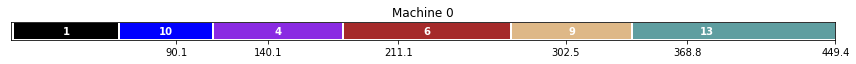

<Figure size 432x288 with 0 Axes>

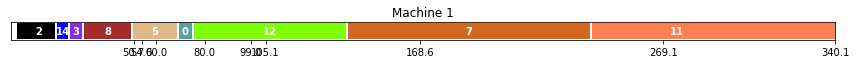

MARGES : 


<Figure size 432x288 with 0 Axes>

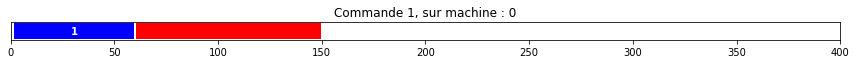

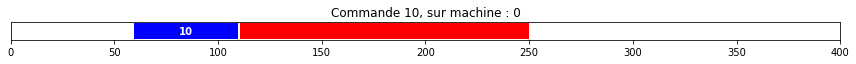

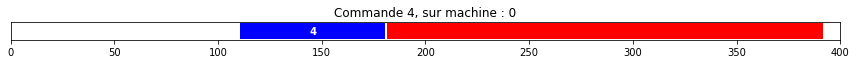

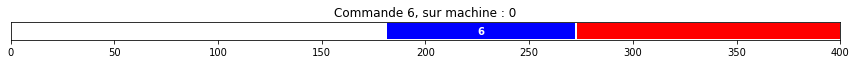

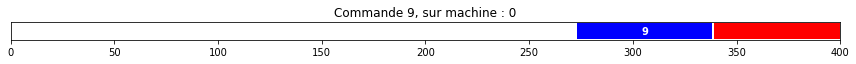

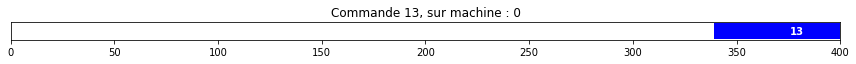

<Figure size 432x288 with 0 Axes>

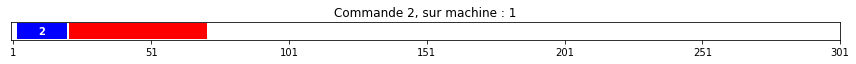

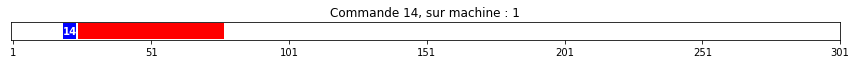

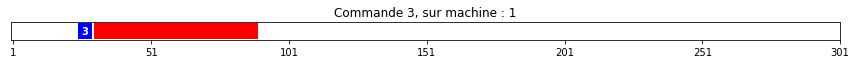

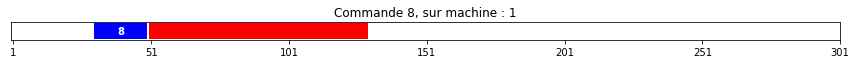

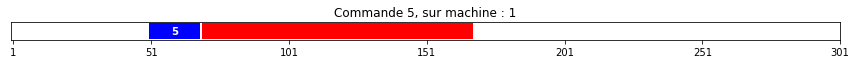

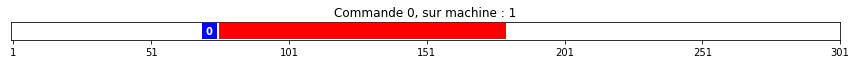

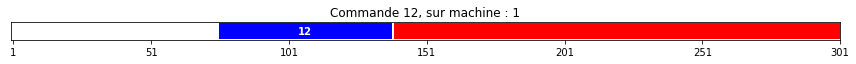

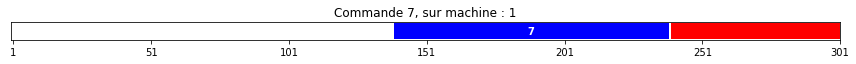

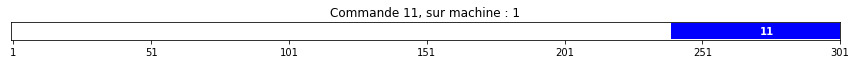

RENDEMENTS : 


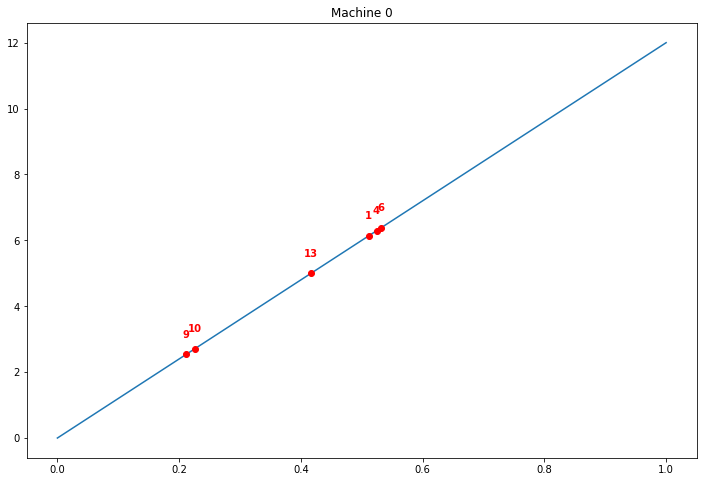

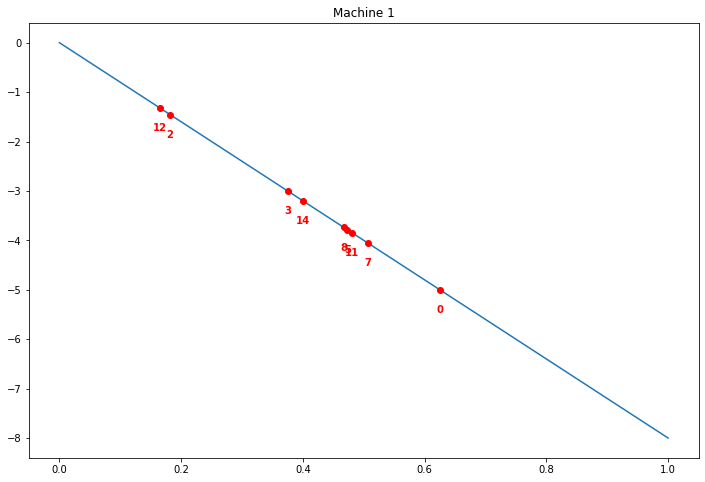

In [311]:
printEDT(var)